In [1]:
# conda install tensorflow-gpu==2.1.0 matplotlib
# pip install sciann
# sciann version: 0.6.3.1
import pathlib
import numpy as np
import time
import sciann as sn
from sciann_datagenerator import DataGeneratorXY
from sciann.utils.math import diff
import tensorflow.keras.callbacks as callbacks
from scipy.special import hankel1
import matplotlib.pyplot as plt
import os

---------------------- SCIANN 0.6.3.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 


In [2]:
def data_tmp(start=0, end=10, num=40000, kk=1, amp=1):
    dg = DataGeneratorXY(
        X=[start, end],
        Y=[start, end],
        targets=["domain","bc-top","bc-bot"],
        num_sample=num,
    )
    dg.plot_data()
    x_data = np.squeeze(dg.input_data[0])
    y_data = np.squeeze(dg.input_data[1])
    
    # Green(x,y) = Hankel_0^1(k * r)
#     u_real = np.real(amp * hankel1(0, kk*rr))
#     u_imag = np.imag(amp * hankel1(0, kk*rr))
    
#     G0_real = np.real(amp * hankel1(0, k0*rr))
#     G0_imag = np.imag(amp * hankel1(0, k0*rr))
    
    # complex valued part is phase shifted by 90°
    return x_data, y_data

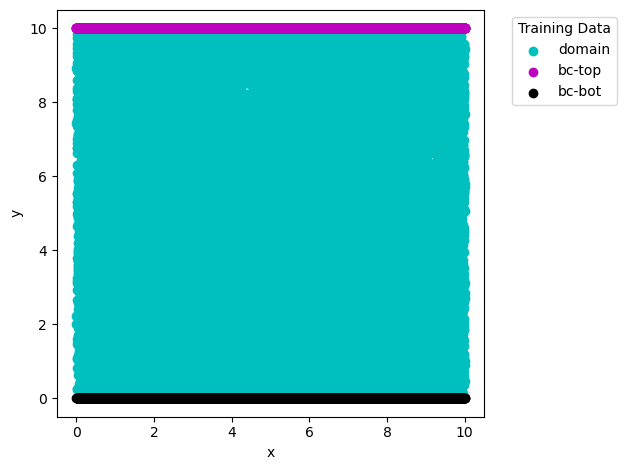


Total samples: 50000 
Batch size: 1024 
Total batches: 49 



KeyboardInterrupt: 

In [4]:
if __name__ == "__main__":
    x_data, y_data = data_tmp(kk=10)

    # prepare data
    x = sn.Variable("x", dtype='float64')
    y = sn.Variable("y", dtype='float64')
    
    sx = sn.Variable("sx", dtype='float64')
    sy = sn.Variable("sy", dtype='float64')
    
    rr = (x - sx)**2 + (y - sy)**2
    # Parameters
    SSP = 1480
    freq = 100
    PI = np.pi
    Omega = 2*PI*freq
    k0 = Omega / 1500
    
    # Functions
    layers = 10*[20]
#     G_real = np.real(np.hankel1(0, k0*rr))
#     G_imag = np.imag(np.hankel1(0, k0*rr))
    G_real = sn.Functional("G_real", [x, y, sx, sy], layers, "l-elu")
    G_imag = sn.Functional("G_imag", [x, y, sx, sy], layers, "l-elu")
    
    p_real = sn.Functional("p_real", [x, y, sx, sy], layers, "l-elu")
    p_imag = sn.Functional("p_imag", [x, y, sx, sy], layers, "l-elu")

    c = sn.Functional("c", [x, y], layers, "l-elu")
    
    # pde ($\Delta p + k^2 \cdot p = 0$) split into real- and complex-valued part
    laplace_re_dp = diff(p_real, x, order=2) + diff(p_real, y, order=2)
    laplace_im_dp = diff(p_imag, x, order=2) + diff(p_imag, y, order=2)
    L1 = sn.rename(laplace_re_dp + (Omega / c)**2 * p_real + ((Omega / c)**2-k0**2)*G_real, 'PDEr')
    L2 = sn.rename(laplace_im_dp + (Omega / c)**2 * p_imag + ((Omega / c)**2-k0**2)*G_imag, 'PDEi')
    
    TOL = 0.0015
    # Neumann boundary B1 (seaface:y=0)
    N1 = sn.rename((1 - sn.sign(y - (0 + TOL))) * (p_real), 'Nr')
    N2 = sn.rename((1 - sn.sign(y - (0 + TOL))) * (p_imag), 'Ni')
    
    # Dirichlet boundary B2 (seabed:y=376)
    D1 = sn.rename((1 - sn.sign(y - (10 + TOL))) * diff( p_real, y, order=1 ), 'Dr')
    D2 = sn.rename((1 - sn.sign(y - (10 + TOL))) * diff( p_imag, y, order=1 ), 'Di')
    
    
    # model and input
    input = [x, y, sx, sy]
    input_value = [x_data, y_data, 0*np.ones(x_data.size), 2*np.ones(x_data.size)]
    target = [L1, L2, N1, N2, D1, D2]
    target_value = ['zeros']*6
    model = sn.SciModel(input, target, optimizer='scipy-l-BFGS-B')

    # callbacks
    current_path = os.path.abspath('')
    checkpoint_filepath = str(os.path.join(current_path, 'callbacks/helmholtz/Green2D_1500.ckpt'))
    save_path = str(os.path.join(current_path, 'model/Green2D_1500.hdf5'))
    model_checkpoint_callback = callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='loss',
        mode='auto',
        save_best_only=True,
        learning_rate=1e-6
    )
    t = time.time()

    history = model.train(
        input_value,
        target_value,
        epochs=500,
        batch_size=1024,
        adaptive_weights={"method": "NTK", "freq": 100},
        callbacks=[model_checkpoint_callback]
    )
    t = time.time() - t

    # sn.SciModel.save(model, filepath=save_path)
    model.save_weights(save_path)

    fig = plt.figure()
    plt.plot(history.history['p_real_loss'], 'r', label='$p_{real}$-loss')
    plt.plot(history.history['p_imag_loss'], 'b', label='$p_{image}$-loss')
    plt.yscale('log')
    plt.xlabel('epoch')
    plt.ylabel('Mean-Squared-Error')
    plt.title('Loss')
    plt.legend()
#     plt.savefig('N2Green_Loss.png')
    # plt.show()

    # predictions
    xx = np.linspace(1, 2, 200)
    yy = np.linspace(1, 2, 200)
    kk = 10 * np.ones(xx.shape)

    x_test, y_test = np.meshgrid(xx, yy)
    k_test = 10 * np.ones(x_test.shape)

    p_real_pred = p_real.eval(model, [x_test, y_test, k_test])
    p_imag_pred = p_imag.eval(model, [x_test, y_test, k_test])

    # exact solution
    p_real_exsol = np.real(hankel1(0, k_test * np.sqrt(x_test ** 2 + y_test ** 2)))
    p_imag_exsol = np.imag(hankel1(0, k_test * np.sqrt(x_test ** 2 + y_test ** 2)))

    # pressure
    # exact solution
    fig2 = plt.figure()
    plt.suptitle('#2-D Exact Solution(left) and Prediction Solution(right)')
    plt.subplot(2, 2, 1)
    plt.pcolor(xx, yy, p_real_exsol, cmap='jet', shading='auto')
    plt.xlabel('x,m')
    plt.ylabel('y,m')
    plt.colorbar()
    plt.title('Real Pressure')

    plt.subplot(2, 2, 3)
    plt.pcolor(xx, yy, p_imag_exsol, cmap='jet', shading='auto')
    plt.xlabel('x,m')
    plt.ylabel('y,m')
    plt.colorbar()
    plt.title('Image Pressure')

    # predict
    plt.subplot(2, 2, 2)
    plt.pcolor(xx, yy, p_real_pred, cmap='jet', shading='auto')
    plt.xlabel('x,m')
    plt.ylabel('y,m')
    plt.colorbar()
    plt.title('Real Pressure')

    plt.subplot(2, 2, 4)
    plt.pcolor(xx, yy, p_imag_pred, cmap='jet', shading='auto')
    plt.xlabel('x,m')
    plt.ylabel('y,m')
    plt.colorbar()
    plt.title('Image Pressure')

    plt.tight_layout()
    plt.savefig('fig2.png')
    plt.show()